In [406]:
import numpy as np
import pandas as pd
import seaborn as sns

# Database used is now the Kaggle files
titanic_train = pd.read_csv('./data/01.Titanic/train.csv')
titanic_test = pd.read_csv('./data/01.Titanic/test.csv')
titanic = pd.concat([titanic_train, titanic_test])

In [407]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



## Clean data

In [409]:
def clean_titanic_df(df):
    # just to avoir issue
    if 'Ticket' in df.columns:
        df.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)
        
        # next keep Name ! Use Mrs. Miss. and Mr.
        df.loc[df['Name'].str.contains('Mrs.'), 'Name'] = 'Mrs'
        df.loc[df['Name'].str.contains('Mme.'), 'Name'] = 'Mrs'
        df.loc[df['Name'].str.contains('Mr.'), 'Name'] = 'Mr'
        df.loc[df['Name'].str.contains('Mlle.'), 'Name'] = 'Miss'
        df.loc[df['Name'].str.contains('Ms.'), 'Name'] = 'Miss'
        df.loc[df['Name'].str.contains('Miss.'), 'Name'] = 'Miss'
        
        # Important states ?
        df.loc[df['Name'].str.contains('Master.'), 'Name'] = 'Master'
        df.loc[df['Name'].str.contains('Rev.'), 'Name'] = 'Rev'
        df.loc[df['Name'].str.contains('Dr.'), 'Name'] = 'Dr'
        df.loc[df['Name'].str.contains('Don.'), 'Name'] = 'Don'
        df.loc[df['Name'].str.contains('Countess.'), 'Name'] = 'Countess'
        df.loc[df['Name'].str.contains('Jonkheer.'), 'Name'] = 'Jonkheer'
        df.loc[df['Name'].str.contains('Col.'), 'Name'] = 'Col'
        
        # Boat states ?
        df.loc[df['Name'].str.contains('Major.'), 'Name'] = 'Boat'
        df.loc[df['Name'].str.contains('Capt.'), 'Name'] = 'Boat'
        
    df['Embarked'].fillna(method='ffill', inplace=True)
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)
    #df['Cabin'].fillna('Unknown', inplace=True)
    #df['Ticket'].fillna('Unknown', inplace=True)

clean_titanic_df(titanic_train)
clean_titanic_df(titanic_test)
clean_titanic_df(titanic)
titanic_train.isnull().any()

Survived    False
Pclass      False
Name        False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

In [410]:
titanic_test['Name'].unique()

array(['Mr', 'Miss', 'Master', 'Col', 'Rev', 'Dr', 'Don'], dtype=object)

In [411]:
titanic_train['Name'].unique()

array(['Mr', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Boat', 'Col',
       'Countess', 'Jonkheer'], dtype=object)

Test data does not contain 'Boat', 'Countess', 'Jonkheer' data so we will removed it

In [412]:
titanic_train = titanic_train.query('Name != "Boat" & Name != "Countess" & Name != "Jonkheer"')
titanic_train['Name'].unique()

array(['Mr', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Col'], dtype=object)

In [413]:
titanic_train.shape

(886, 9)

In [414]:
titanic_test.shape

(418, 8)

## Write Output function

In [444]:
def write_output(model, filename, test_data):
    pred = model.predict(test_data)
    
    # to improve, here we reload data
    test = pd.read_csv('./data/01.Titanic/test.csv')
    path = "./data/01.Titanic/" + filename
    with open(path,'w') as f:
        f.write("PassengerId,Survived")
        f.write('\n')
        for i in range(0, len(pred)):
            passenger_id = test['PassengerId'].iloc[i]
            f.write("{},{} ".format(passenger_id, pred[i]))
            f.write('\n')

Check if perhaps better to use fillna later!

## Display quick information about dataset

In [399]:
#  pivot tables can be specified with multiple levels
# using pd.cut to get age intervals
age = pd.cut(titanic['Age'], [0, 18, 80])
titanic.pivot_table('Survived', ['Sex', age], 'Pclass')

Pclass                  1         2         3
Sex    Age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.975904  0.903226  0.495050
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.350427  0.086022  0.121622

In [400]:
# using pd.qcut to automatically compute quantiles
fare = pd.qcut(titanic['Fare'], 2)
# Sex and age use as multi Index
# Fare pair and class use as columns
titanic.pivot_table('Survived', ['Sex', age], [fare, 'Pclass'])

Fare            (-0.001, 14.454]                     (14.454, 512.329]  \
Pclass                         1         2         3                 1   
Sex    Age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.884615  0.533333          0.975904   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.118644  0.106122          0.369369   

Fare                                 
Pclass                  2         3  
Sex    Age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.916667  0.439024  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.029412  0.196078

Seems class, age and sex are great features. Later we will take look at all correlation between these variables. Now let clean data and select features we want.

## Identify correlations between data

/Users/jeromebuisine/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


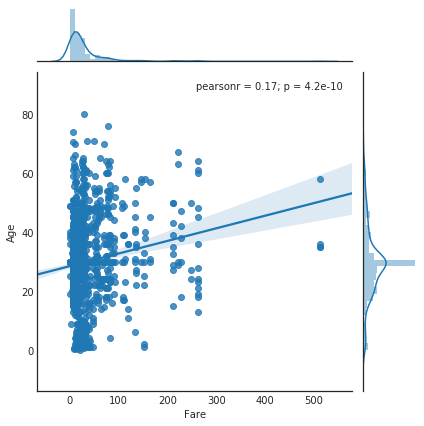

In [401]:
from matplotlib import pyplot as plt
plt.style.context('ggplot')

with sns.axes_style('white'):
    sns.jointplot("Fare", "Age", titanic, kind='reg')

Coefficient of correlation is very low, furthermore, p-value is > 5%.

/Users/jeromebuisine/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


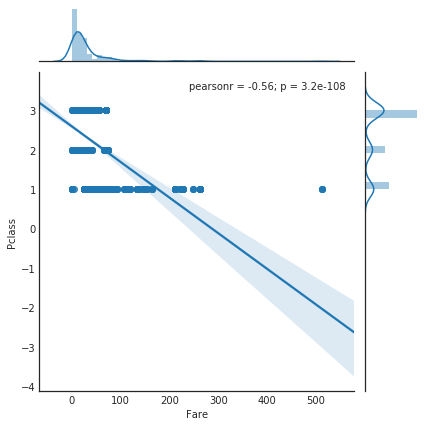

In [402]:
with sns.axes_style('white'):
    sns.jointplot("Fare", "Pclass", titanic, kind='reg')

pclass and fare seem to be significative. Correlation is present, furthermore, p-value is < 5%, so statistically it's significative.


Let's now take a look at data 'survived' which is the data we want to explain.

/Users/jeromebuisine/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


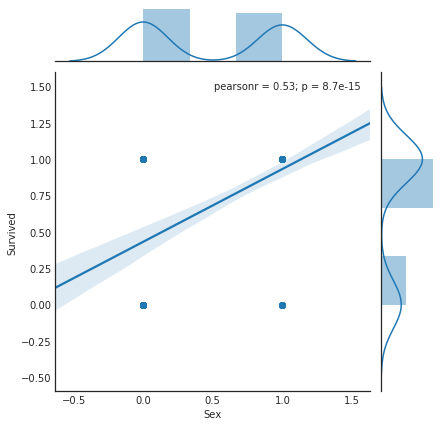

In [106]:
cp_clean_titanic = titanic.copy()

cp_clean_titanic['Sex'] = cp_clean_titanic['Sex'].map({'female': 1, 'male': 0})

with sns.axes_style('white'):
    sns.jointplot("Sex", "Survived", cp_clean_titanic, kind='reg')

/Users/jeromebuisine/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


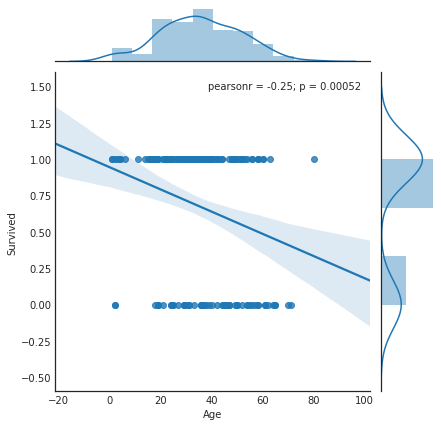

In [107]:
cp_clean_titanic = titanic.copy()

cp_clean_titanic['Sex'] = cp_clean_titanic['Sex'].map({'female': 1, 'male': 0})

with sns.axes_style('white'):
    sns.jointplot("Age", "Survived", cp_clean_titanic, kind='reg')

Seems strange but age does not involve directly with survived. Perhaps, Pclass or sex are more important critria to be combine with age.

/Users/jeromebuisine/.pyenv/versions/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


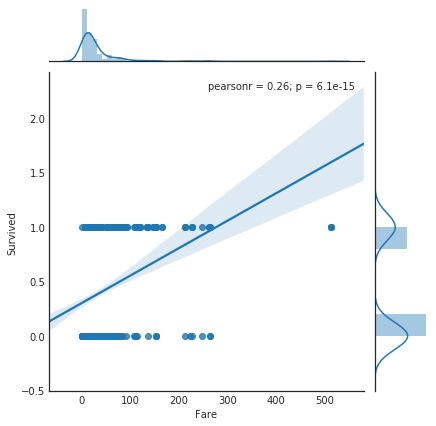

In [36]:
cp_clean_titanic = titanic.copy()

cp_clean_titanic['Sex'] = cp_clean_titanic['Sex'].map({'female': 1, 'male': 0})

with sns.axes_style('white'):
    sns.jointplot("Fare", "Survived", cp_clean_titanic, kind='reg')

With information obtained with these correlation, let's try using Logistic Regression. But before we have to select our features.

## Features selection

In [359]:
# Just to remember
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,Unknown,S
1,1,1,Mr,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S
3,1,1,Mr,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,Mr,male,35.0,0,0,373450,8.0500,Unknown,S


In [360]:

titanic_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,Mr,male,34.5,0,0,330911,7.8292,Unknown,Q
1,3,Mr,female,47.0,1,0,363272,7.0000,Unknown,S
2,2,Mr,male,62.0,0,0,240276,9.6875,Unknown,Q
3,3,Mr,male,27.0,0,0,315154,8.6625,Unknown,S
4,3,Mr,female,22.0,1,1,3101298,12.2875,Unknown,S


In [404]:
# target array
y_titanic = titanic_train['Survived']
y_titanic.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [415]:
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing

# Split DATA
# drop species target array for features matrix
def setup_dataframe(df):
    currentDf = df.copy()
    if 'Survived' in df.columns:
        currentDf.drop(['Survived'], axis=1, inplace=True)
        # Make only classes for ages using cut ?
        #currentDf['Age'] = pd.cut(currentDf['Age'], [0, 10, 18, 40, 80])
    
    currentDf = pd.get_dummies(currentDf)
    
    #vec = DictVectorizer(sparse=True, dtype=int)
    #currentDf = vec.fit_transform(currentDf.T.to_dict().values())
    #return(pd.DataFrame(currentDf.toarray()))
    return(currentDf)
    
# then drop survided col
X_titanic = setup_dataframe(titanic_train)
X_titanic_test = setup_dataframe(titanic_test)

print(X_titanic.shape)
print(X_titanic_test.shape)

# make dataset
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=0)

(886, 17)
(418, 17)


## Logistic Regression

In [445]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=0)

from sklearn import metrics
logreg_m = LogisticRegression()
logreg_m.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [446]:
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg_m.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.8158


80% is correct but we can do better! Perhaps change kernel approximation

In [447]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(logreg_m, X_titanic, y_titanic, cv=5)
print('Accuracy of logistic regression classifier with cross validation: {:.4f}'.format(scores.mean()))
#logreg_m.predict(X_titanic_test)

Accuracy of logistic regression classifier with cross validation: 0.8217


In [448]:
write_output(logreg_m, 'output.csv', X_titanic_test)

## Naive Bayesian classification

### Gaussian Naive Bayesian classification

In [320]:
from sklearn.naive_bayes import GaussianNB
g_model = GaussianNB()
g_model.fit(X_train, y_train);

In [321]:
print('Accuracy of Gaussian Naive Bayesian classification on test set: {:.4f}'.format(g_model.score(X_test, y_test)))

Accuracy of Gaussian Naive Bayesian classification on test set: 0.4515


In [322]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(g_model, X_titanic, y_titanic, cv=5)
print('Accuracy of Gaussian Naive Bayesian classification with cross validation: {:.4f}'.format(scores.mean()))

Accuracy of Gaussian Naive Bayesian classification with cross validation: 0.4725


### Multinomial Naive Bayesian classification

In [323]:
from sklearn.naive_bayes import MultinomialNB
m_model = MultinomialNB()
m_model.fit(X_train, y_train);
print('Accuracy of Multinomial Naive Bayesian classification on test set: {:.4f}'.format(m_model.score(X_test, y_test)))

Accuracy of Multinomial Naive Bayesian classification on test set: 0.7276


In [324]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(m_model, X_titanic, y_titanic, cv=5)
print('Accuracy of Multinomial Naive Bayesian classification with cross validation: {:.4f}'.format(scores.mean()))

Accuracy of Multinomial Naive Bayesian classification with cross validation: 0.6937


Globally, Naive Bayesian seems to not be the best model (perhaps parameters ?).

## Try using PCA which is a fast linear dimensionality reduction technique

In [325]:
# Try separate data using PCA
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X_titanic)                      # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(X_titanic)         # 4. Transform the data to two dimensions

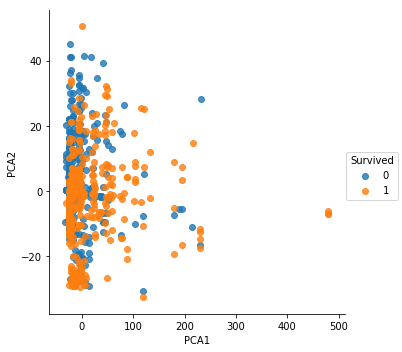

In [326]:
# let's plot result
titanic_train['PCA1'] = X_2D[:, 0]
titanic_train['PCA2'] = X_2D[:, 1]
sns.lmplot("PCA1", "PCA2", hue='Survived', data=titanic_train, fit_reg=False);

PCA seems to not be the great model for this problem. Later we will try improve PCA performance by changing features selected. Then, try using logistic regression on that or SVM.

## Test using Support Vector Classifier with PCA data

In [327]:
# function for plotting 2D SVC
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [328]:
from sklearn.svm import SVC # "Support vector classifier"

clf = SVC(kernel='rbf', C=1E6)
X_PCA = titanic_train[['PCA1', 'PCA2']]
y_PCA = titanic_train['Survived']
clf.fit(X_PCA, y_PCA)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

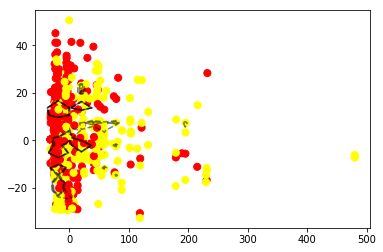

In [329]:
plt.scatter(titanic_train['PCA1'], titanic_train['PCA2'], c=y_PCA, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

In [330]:
# probably due to overfitting
print('Accuracy of Support vector classification on test set: {:.2f}'.format(clf.score(X_PCA, y_PCA)))

Accuracy of Support vector classification on test set: 0.96


In [331]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(clf, X_PCA, y_PCA, cv=5)
print('Accuracy of Support vector classification with cross validation: {:.2f}'.format(scores.mean()))

Accuracy of Support vector classification with cross validation: 0.62


## Test using Logistic Regression with PCA data

In [332]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y_PCA, test_size=0.3, random_state=0)

from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_PCA_train, y_PCA_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [333]:
print('Accuracy of logistic regression classifier on PCA test set: {:.2f}'.format(logreg.score(X_PCA_test, y_PCA_test)))

Accuracy of logistic regression classifier on PCA test set: 0.69


In [334]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(logreg, X_PCA, y_PCA, cv=5)
print('Accuracy of logistic regression classifier with cross validation on PCA set: {:.2f}'.format(scores.mean()))

Accuracy of logistic regression classifier with cross validation on PCA set: 0.66


## Create output file

Here methods seems to give often results in same range. One thing to do is to clear data and adapt it more. We have to take care of the most important columns, checking correlation between them and create new column if necessary. So go to Second part of Kaggle Titanic.